In [5]:
# FRAUDULENT TRANSACTIONS DETECTION PROJECT

# ================= Imports =================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [6]:
try:
    from imblearn.under_sampling import RandomUnderSampler
except:
    print("imblearn not found. Proceeding without resampling.")
    RandomUnderSampler = None

In [4]:
# ================= Configuration =================
data_path = "Fraud.csv"
SAMPLE = False
SAMPLE_FRAC = 0.05
RANDOM_STATE = 42

In [7]:
# ================= Data Loading =================
print("Loading data:", data_path)
df = pd.read_csv(data_path)
print("Initial shape:", df.shape)
if SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Sampled:", df.shape)

Loading data: Fraud.csv
Initial shape: (6362620, 11)


In [14]:
# ================= EDA =================
print("\nHEAD:\n", df.head().T)



HEAD:
                           0            1            2           3            4
step                      1            1            1           1            1
type                PAYMENT      PAYMENT     TRANSFER    CASH_OUT      PAYMENT
amount              9839.64      1864.28        181.0       181.0     11668.14
nameOrig        C1231006815  C1666544295  C1305486145  C840083671  C2048537720
oldbalanceOrg      170136.0      21249.0        181.0       181.0      41554.0
newbalanceOrig    160296.36     19384.72          0.0         0.0     29885.86
nameDest        M1979787155  M2044282225   C553264065   C38997010  M1230701703
oldbalanceDest          0.0          0.0          0.0     21182.0          0.0
newbalanceDest          0.0          0.0          0.0         0.0          0.0
isFraud                   0            0            1           1            0
isFlaggedFraud            0            0            0           0            0


In [9]:
print("\nINFO:\n"); print(df.info())


INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [10]:
print("\nMISSING VALUES:\n", df.isnull().sum())


MISSING VALUES:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [11]:
print("\nTarget Distribution (isFraud):\n", df['isFraud'].value_counts(normalize=True))


Target Distribution (isFraud):
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [12]:
print("\nisFlaggedFraud distribution:\n", df['isFlaggedFraud'].value_counts())


isFlaggedFraud distribution:
 isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


In [13]:
print("\nNUMERIC SUMMARY:\n", df.select_dtypes(include=[np.number]).describe().T)


NUMERIC SUMMARY:
                     count          mean           std  min       25%  \
step            6362620.0  2.433972e+02  1.423320e+02  1.0    156.00   
amount          6362620.0  1.798619e+05  6.038582e+05  0.0  13389.57   
oldbalanceOrg   6362620.0  8.338831e+05  2.888243e+06  0.0      0.00   
newbalanceOrig  6362620.0  8.551137e+05  2.924049e+06  0.0      0.00   
oldbalanceDest  6362620.0  1.100702e+06  3.399180e+06  0.0      0.00   
newbalanceDest  6362620.0  1.224996e+06  3.674129e+06  0.0      0.00   
isFraud         6362620.0  1.290820e-03  3.590480e-02  0.0      0.00   
isFlaggedFraud  6362620.0  2.514687e-06  1.585775e-03  0.0      0.00   

                       50%           75%           max  
step               239.000  3.350000e+02  7.430000e+02  
amount           74871.940  2.087215e+05  9.244552e+07  
oldbalanceOrg    14208.000  1.073152e+05  5.958504e+07  
newbalanceOrig       0.000  1.442584e+05  4.958504e+07  
oldbalanceDest  132705.665  9.430367e+05  3.560

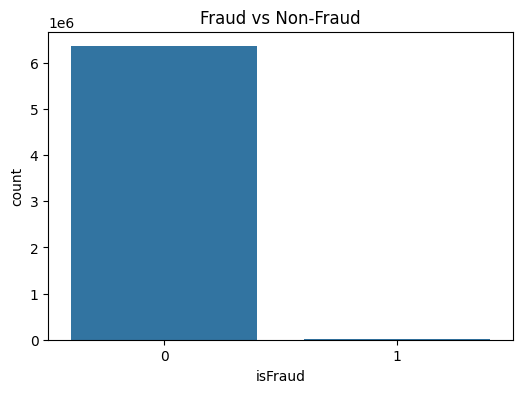

In [16]:
# ================= Visualization =================
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()



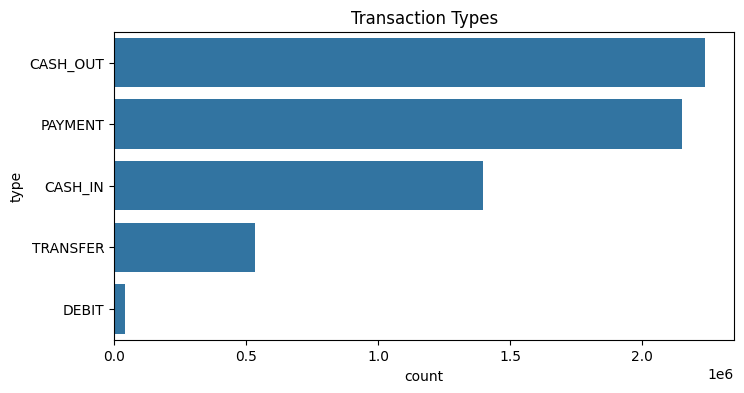

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(y='type', data=df, order=df['type'].value_counts().index)
plt.title("Transaction Types")
plt.show()

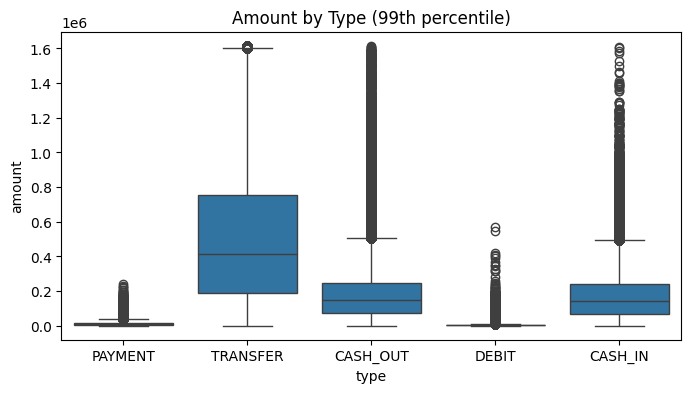

In [18]:
plt.figure(figsize=(8,4))
sns.boxplot(x='type', y='amount', data=df[df['amount']<df['amount'].quantile(0.99)])
plt.title("Amount by Type (99th percentile)")
plt.show()

In [19]:
# ================= Feature Engineering =================
df_fe = df.copy()
df_fe['amount_log'] = np.log1p(df_fe['amount'])
df_fe['orig_balance_change'] = df_fe['newbalanceOrig'] - df_fe['oldbalanceOrg']
df_fe['dest_balance_change'] = df_fe['newbalanceDest'] - df_fe['oldbalanceDest']
df_fe['isHighAmount'] = (df_fe['amount'] > 200000).astype(int)
df_fe['hour_of_day'] = df_fe['step'] % 24
df_fe['isMerchantDest'] = df_fe['nameDest'].astype(str).str.startswith('M').astype(int)
df_fe['isSelfTransfer'] = (df_fe['nameOrig'] == df_fe['nameDest']).astype(int)

features = [
    'type', 'amount_log', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'orig_balance_change', 'dest_balance_change',
    'isHighAmount', 'hour_of_day', 'isMerchantDest', 'isSelfTransfer', 'isFlaggedFraud'
]

X = df_fe[features]
# Ensure target has no missing or infinite values
df_fe['isFraud'] = pd.to_numeric(df_fe['isFraud'], errors='coerce')
df_fe['isFraud'] = df_fe['isFraud'].fillna(0)  # replace NaN with 0 (non-fraud)
df_fe['isFraud'].replace([np.inf, -np.inf], 0, inplace=True)
y = df_fe['isFraud'].astype(int)

In [20]:
# ================= Train-Test Split =================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5090096, 14) Test shape: (1272524, 14)


In [21]:
# ================= Preprocessing =================
cat_features = ['type', 'hour_of_day', 'isMerchantDest', 'isSelfTransfer', 'isHighAmount', 'isFlaggedFraud']
num_features = [
    'amount_log', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'orig_balance_change', 'dest_balance_change'
]

preprocessor = ColumnTransformer([
    ('ohe_type', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['type']),
    ('num', 'passthrough', num_features),
    ('bin', 'passthrough', ['hour_of_day', 'isMerchantDest', 'isSelfTransfer', 'isHighAmount', 'isFlaggedFraud'])
], remainder='drop', sparse_threshold=0)

In [22]:
# ================= Handling Imbalance =================
print("\nClass imbalance before resampling:", np.bincount(y_train))
USE_UNDERSAMPLE = True
if USE_UNDERSAMPLE and RandomUnderSampler:
    tmp_pipeline = Pipeline([('pre', preprocessor)])
    X_train_trans = tmp_pipeline.fit_transform(X_train)
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    X_train_final, y_train_final = rus.fit_resample(X_train_trans, y_train)
    X_test_final = tmp_pipeline.transform(X_test)
    PREPROCESSOR_PIPELINE = tmp_pipeline
else:
    PREPROCESSOR_PIPELINE = Pipeline([('pre', preprocessor), ('scaler', StandardScaler(with_mean=False))])
    X_train_final = PREPROCESSOR_PIPELINE.fit_transform(X_train)
    X_test_final = PREPROCESSOR_PIPELINE.transform(X_test)
    y_train_final, y_test_final = y_train, y_test

print("Final training matrix:", X_train_final.shape)


Class imbalance before resampling: [5083526    6570]
Final training matrix: (13140, 18)


In [23]:
# ================= Modeling =================
def evaluate_model(name, model, X_test_arr, y_test_arr):
    y_proba = model.predict_proba(X_test_arr)[:,1] if hasattr(model,"predict_proba") else None
    y_pred = (y_proba >= 0.5).astype(int) if y_proba is not None else model.predict(X_test_arr)
    print(f"\n{name} Evaluation")
    print("Confusion Matrix:\n", confusion_matrix(y_test_arr, y_pred))
    print("Classification Report:\n", classification_report(y_test_arr, y_pred, digits=4))
    if y_proba is not None:
        roc = roc_auc_score(y_test_arr, y_proba)
        avg_prec = average_precision_score(y_test_arr, y_proba)
        print(f"ROC AUC: {roc:.4f}, Average Precision: {avg_prec:.4f}")
        fpr, tpr, _ = roc_curve(y_test_arr, y_proba)
        precision, recall, _ = precision_recall_curve(y_test_arr, y_proba)
        plt.figure(figsize=(6,4)); plt.plot(fpr, tpr); plt.title(f"ROC - {name}"); plt.show()
        plt.figure(figsize=(6,4)); plt.plot(recall, precision); plt.title(f"PR Curve - {name}"); plt.show()


Training Logistic Regression...

Logistic Regression Evaluation
Confusion Matrix:
 [[1212869   58012]
 [     90    1553]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9544    0.9766   1270881
           1     0.0261    0.9452    0.0507      1643

    accuracy                         0.9543   1272524
   macro avg     0.5130    0.9498    0.5137   1272524
weighted avg     0.9987    0.9543    0.9754   1272524

ROC AUC: 0.9914, Average Precision: 0.5692


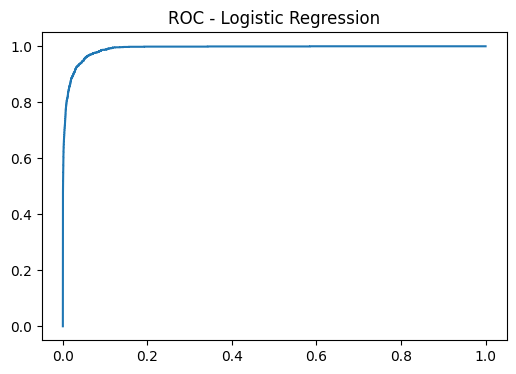

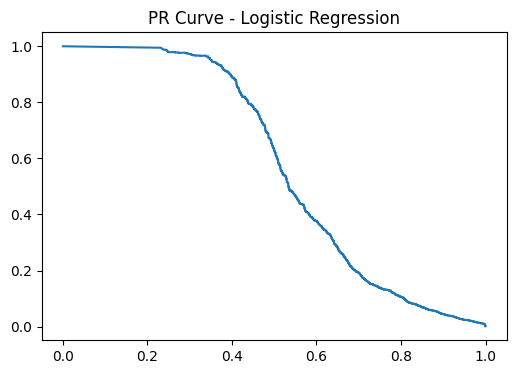

In [24]:
print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_final, y_train_final)
evaluate_model("Logistic Regression", lr, X_test_final, y_test)


Training Random Forest...

Random Forest Evaluation
Confusion Matrix:
 [[1260823   10058]
 [      3    1640]]
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9921    0.9960   1270881
           1     0.1402    0.9982    0.2459      1643

    accuracy                         0.9921   1272524
   macro avg     0.5701    0.9951    0.6209   1272524
weighted avg     0.9989    0.9921    0.9951   1272524

ROC AUC: 0.9994, Average Precision: 0.8255


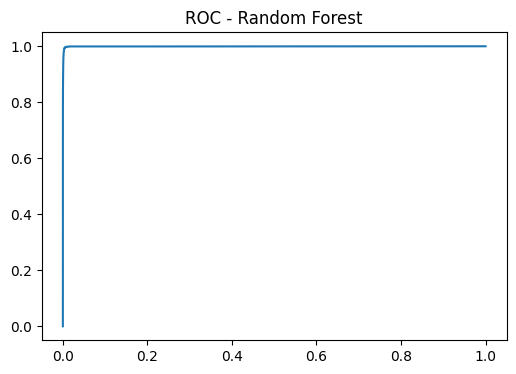

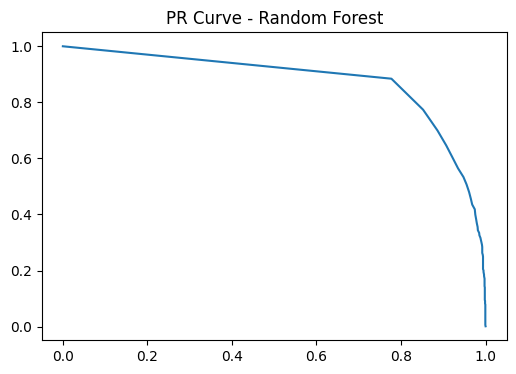

In [26]:
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE)
rf.fit(X_train_final, y_train_final)
evaluate_model("Random Forest", rf, X_test_final, y_test)


Training XGBoost...

XGBoost Evaluation
Confusion Matrix:
 [[1260858   10023]
 [      2    1641]]
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9921    0.9960   1270881
           1     0.1407    0.9988    0.2466      1643

    accuracy                         0.9921   1272524
   macro avg     0.5703    0.9954    0.6213   1272524
weighted avg     0.9989    0.9921    0.9951   1272524

ROC AUC: 0.9995, Average Precision: 0.8984


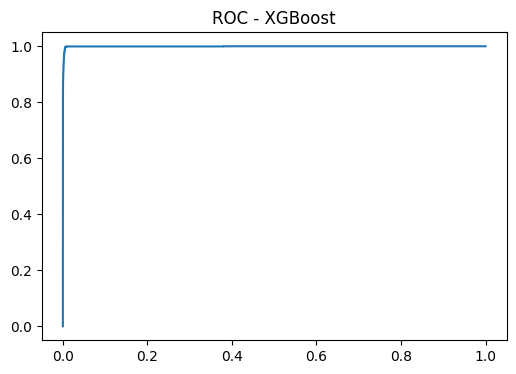

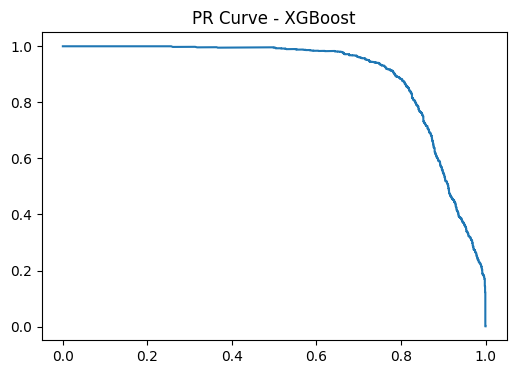

In [27]:
print("\nTraining XGBoost...")
xgb = XGBClassifier(
    n_estimators=200, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1
)
xgb.fit(X_train_final, y_train_final)
evaluate_model("XGBoost", xgb, X_test_final, y_test)

In [28]:
# ================= Feature Importance =================
def get_feature_names(preproc):
    ohe = preproc.named_transformers_['ohe_type']
    ohe_features = [f"type_{c}" for c in ohe.categories_[0].tolist()]
    num_bins = ['hour_of_day','isMerchantDest','isSelfTransfer','isHighAmount','isFlaggedFraud']
    return ohe_features + num_features + num_bins

try:
    preproc = PREPROCESSOR_PIPELINE.named_steps.get('pre', PREPROCESSOR_PIPELINE)
    feature_names = get_feature_names(preproc)
except:
    feature_names = [f"f{i}" for i in range(X_train_final.shape[1])]


Top Random Forest Features:
 orig_balance_change    0.319557
oldbalanceOrg          0.162954
newbalanceOrig         0.098279
amount_log             0.084727
amount                 0.064877
type_TRANSFER          0.044973
dest_balance_change    0.042838
hour_of_day            0.030982
type_PAYMENT           0.030030
isMerchantDest         0.028904
newbalanceDest         0.027576
oldbalanceDest         0.020617
type_CASH_IN           0.018680
type_CASH_OUT          0.014055
isHighAmount           0.009816
dtype: float64


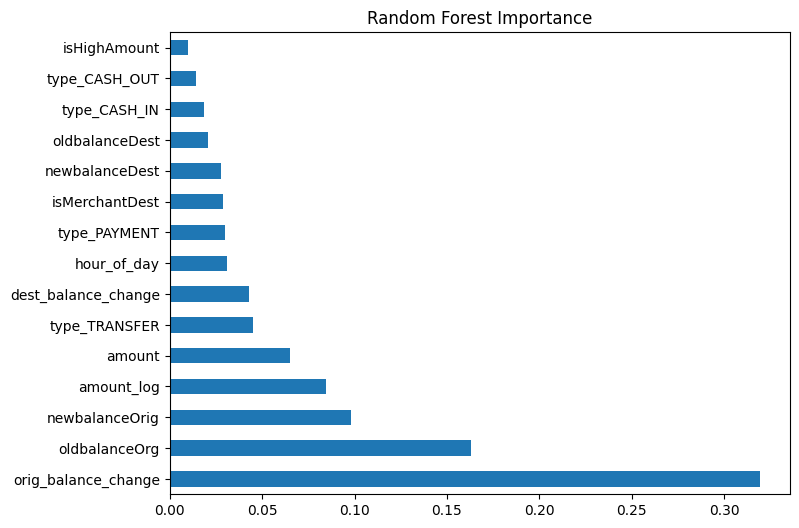

In [29]:
if hasattr(rf, 'feature_importances_'):
    fi_rf = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
    print("\nTop Random Forest Features:\n", fi_rf.head(15))
    plt.figure(figsize=(8,6)); fi_rf.head(15).plot(kind='barh'); plt.title("Random Forest Importance"); plt.show()


Top XGBoost Features:
 orig_balance_change    0.363619
type_PAYMENT           0.153818
newbalanceOrig         0.137797
type_TRANSFER          0.110328
amount_log             0.051730
isFlaggedFraud         0.040794
hour_of_day            0.032965
type_CASH_OUT          0.029044
newbalanceDest         0.027639
type_DEBIT             0.018737
oldbalanceOrg          0.018701
dest_balance_change    0.010276
oldbalanceDest         0.004552
type_CASH_IN           0.000000
amount                 0.000000
dtype: float32


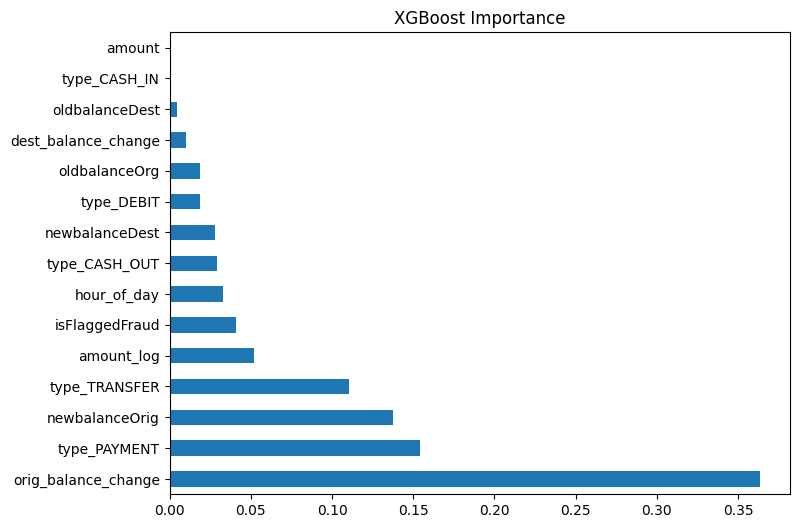

In [30]:
if hasattr(xgb, 'feature_importances_'):
    fi_xgb = pd.Series(xgb.feature_importances_, index=feature_names).sort_values(ascending=False)
    print("\nTop XGBoost Features:\n", fi_xgb.head(15))
    plt.figure(figsize=(8,6)); fi_xgb.head(15).plot(kind='barh'); plt.title("XGBoost Importance"); plt.show()

In [32]:
# ================= Insights =================
print("\n\nBUSINESS INSIGHTS & ACTIONABLE PLAN\n")
print("1) Key Predictors:", fi_rf.head(5).index.tolist() if 'fi_rf' in locals() else "(Unavailable)")
print("2) Fraud Patterns: High-value non-merchant transfers, quick balance drops, repeated transfers.")
print("3) Action Plan: Rule-based + Model-based detection; hold risky transfers for verification.")
print("4) Feedback Loop: Collect outcomes, retrain regularly, monitor drift.")
print("5) Next Steps: Add temporal, graph, and sequence features for improved recall.\n")
print("Run complete")



BUSINESS INSIGHTS & ACTIONABLE PLAN

1) Key Predictors: ['orig_balance_change', 'oldbalanceOrg', 'newbalanceOrig', 'amount_log', 'amount']
2) Fraud Patterns: High-value non-merchant transfers, quick balance drops, repeated transfers.
3) Action Plan: Rule-based + Model-based detection; hold risky transfers for verification.
4) Feedback Loop: Collect outcomes, retrain regularly, monitor drift.
5) Next Steps: Add temporal, graph, and sequence features for improved recall.

Run complete
